<p style="color:#050166; text-align:center; font-size:36px; font-weight:bold;">
Session #3 - Computer vision with Deep Learning
</p>

    

<p style="color:#6ABCF9; text-align:center; font-size:36px; font-weight:bold;">
Advanced AI
</p>

<p style="text-align:center;">
  <img src="Captura de pantalla 2025-08-27 a las 21.22.58.png" alt="my image" width="120" height="80">
</p>

***<p style="text-align: center;">Prof. Beatriz Blanc</p>***
***<p style="text-align: center;">bblanc@faculty.ie.edu</p>***

***

### This session covers:

1. What is computer vision?
2. Computer vision applications
3. Image classification
    1. CNNs architecture
    2. Build our own image classifier
    3. Pre-trained models: AlexNet and ResNet

***

### 3.B. Build your own classifier

In this notebook we are going to create our own classifier.

We are going to use the MINST dataset, a collection of images of hand-written digits. <br>
It includes 60k training images and 10k testing images, all of which are grayscale and 28×28 pixels in size.

This dataset is available in the ``torchvision`` module of pytorch. Torchvision includes several image datasets that can be used for training and testing neural networks.

Let's begin!

#### Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
from torch import optim, nn
from torch.utils.data import DataLoader
from tqdm import tqdm # install (not available in our initial environment) - module for showing progress of execution

import torchvision

import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torchmetrics

#### Load data

1. Download and convert the **MNIST** dataset into a ``tensor``.
2. Use [DataLoader](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html) to handle batching and shuffling both the train and test datasets. A PyTorch ``DataLoader`` can be created from a ``Dataset`` to load data, split it into batches, and perform transformations on the data if desired. Then, it yields a data sample ready for training.

In [5]:
batch_size = 60

train_dataset = datasets.MNIST(root="dataset/", download=True, train=True, transform=transforms.ToTensor()) # downloading the training images
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root="dataset/", download=True, train=False, transform=transforms.ToTensor())
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# Overall, this code prepares the MNIST dataset for training and testing by creating data loaders that will feed batches of images to a model during training and evaluation.
# Optionally, the train dataset could be further split into two partitions of train and validation. Here for simplicity we won't be splitting the training data any more.

Now that we have downloaded the data, let's take a look at it

In order to do that, we are going to apply some transformations to the data so we can plot several images using ``matplotlib``

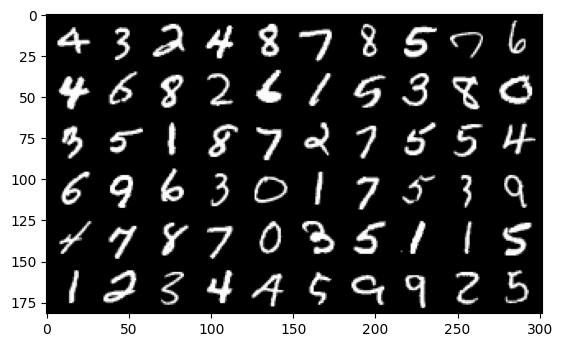

In [6]:
def imshow(img):
   npimg = img.numpy()
   plt.imshow(np.transpose(npimg, (1, 2, 0))) # PyTorch image tensors are usually shaped (C, H, W) - matplotlib.pyplot.imshow() expects (H, W, C) 
   plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images, nrow=10))

#### Define the CNN architecture

To create our classification system we will leverage ``nn.Module`` class. This is PyTorch’s building block for creating neural network architectures.

In the code below, we create a class called ``CNN``, which inherits the properties of ``nn.Module`` class (standard way of creating our own NN) <br>
The ``CNN`` class will be the blueprint of a CNN with two convolutional layers, followed by a fully connected layer. 

1. In PyTorch, we use ``nn.Conv2d`` to define a **convolutional layer**. We pass it the number of input and output feature maps. <br>
We also set some of the parameters for the convolutional layer to work, including the *kernel* or *filter size* and *padding*. The *padding* is the number of pixels that we add in the border of the image so the filter can cover well the edges. **Valid padding** means no padding.

2. Next, we add a **max pooling layer** with ``nn.MaxPool2d``. In it, we slide a non-overlapping window over the output of the previous convolutional layer. At each position, we select the maximum value from the window to pass forward. This operation **reduces the spatial dimensions** of the feature maps, reducing the number of parameters and computational complexity in the network. <br>

<p style="text-align:left;">
  <img src="Captura de pantalla 2025-09-21 a las 21.06.54.png" alt="my image" width="500" height="300">
</p>

3. The ``forward()`` function defines how the different layers are connected, adding several **ReLU** activation functions after each convolutional layer.

4. Finally, we add a **fully connected linear layer**.

In [7]:
class CNN(nn.Module):
   def __init__(self, in_channels, num_classes):

       """
       params:
       in_channels: Number of channels in the input image (for grayscale images, 1)
       num_classes: Number of classes to predict. In our problem, as we have digits from 0 to 9, 10.
       """
       super(CNN, self).__init__()

       # 1st convolutional layer
       self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, padding=1) # out_channels is the number of filters that we want to apply in the conv layer
       # Max pooling layer
       self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
       # 2nd convolutional layer
       self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
       # Fully connected layer
       self.fc1 = nn.Linear(16 * 7 * 7, num_classes) # after all the operations, the size of our feature maps has been reduced to from 28x28 to 7x7

   def forward(self, x):
       """
       params:
       x: Input tensor.

       Returns:
       torch.Tensor: The output tensor after passing through the network.
       """
       x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
       # print(x.shape)
       x = self.pool(x)         # Apply max pooling
       x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = x.reshape(x.shape[0], -1)  # Flatten the tensor
       x = self.fc1(x)   # Apply fully connected layer
       return x

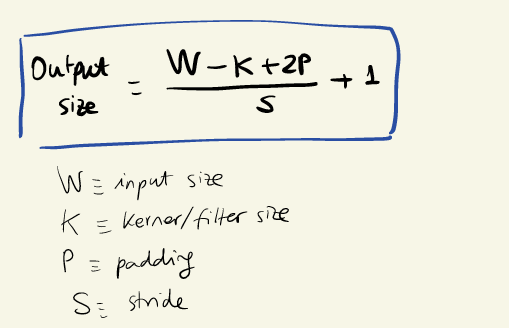

In [8]:
w = 28
k = [3,2,3,2]
p = [1,0,1,0]
s = [1,2,1,2]
for i in range(len(k)):
    output_size = ((w-k[i]+(2*p[i]))/s[i]) + 1
    w = output_size
output_size

7.0

In [9]:
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Metal GPU
elif torch.cuda.is_available():
    device = torch.device("cuda") # NVIDIA GPU (not typical on Mac)
    print("cuda")
else:
    device = torch.device("cpu")

cuda


In [10]:
model = CNN(in_channels=1, num_classes=10).to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)


Now that we have our model, it’s time to **train it**. <br>
To do so, we first will need to determine how we will measure the performance of the model. Since we are dealing with a multi-class classification problem, we will use the cross-entropy loss function, available in PyTorch as ``nn.CrossEntropyLoss``. We will also use ``Adam`` optimizer, one of the most popular optimization algorithms.

Cross-entropy loss is the standard for classification because it directly measures how well the predicted probability distribution matches the true labels, with strong penalties for confident mistakes

In [11]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

We will iterate over ten epochs and training batches to train the model and perform the usual sequence of steps for each batch, as shown below.

An epoch is a single pass over the complete training dataset constitutes an epoch in deep learning.

In [12]:
# your code here

num_epochs = 10

for epoch in range(num_epochs):
    print(f'Epoch [{epoch +1}/{num_epochs}]')   
    
    for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        targets = targets.to(device)
        scores = model(data)
        
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        
    

Epoch [1/10]


100%|██████████| 1000/1000 [00:05<00:00, 172.73it/s]


Epoch [2/10]


100%|██████████| 1000/1000 [00:05<00:00, 191.91it/s]


Epoch [3/10]


100%|██████████| 1000/1000 [00:05<00:00, 190.60it/s]


Epoch [4/10]


100%|██████████| 1000/1000 [00:05<00:00, 190.26it/s]


Epoch [5/10]


100%|██████████| 1000/1000 [00:05<00:00, 187.40it/s]


Epoch [6/10]


100%|██████████| 1000/1000 [00:05<00:00, 190.31it/s]


Epoch [7/10]


100%|██████████| 1000/1000 [00:05<00:00, 190.38it/s]


Epoch [8/10]


100%|██████████| 1000/1000 [00:05<00:00, 193.53it/s]


Epoch [9/10]


100%|██████████| 1000/1000 [00:05<00:00, 197.75it/s]


Epoch [10/10]


100%|██████████| 1000/1000 [00:05<00:00, 195.88it/s]


#### Model evaluation

Once the model is trained, we can evaluate its performance on the **test dataset**. <br>
We will use **accuracy**, a common metric for classification. Accuracy measures the proportion of correctly classified cases from the total number of objects in the dataset. It’s calculated by dividing the number of correct predictions by the total number of predictions made by the model. 

First, we set up the accuracy metric from ``torchmetrics``. Next, we use the ``.eval`` method of the model to put the model in evaluation mode, because some layers in PyTorch models behave differently at training versus testing stages. 
We also add a Python context with ``torch.no_grad``, indicating we will not be performing gradient calculation as we are not training the network anymore:

* If you’re optimizing weights, you need gradients.
* If you’re just measuring accuracy / making predictions, you don’t.

Then, we iterate over test examples with no gradient calculation. <br>
For each test batch, we get model outputs, take the most likely class, and pass it to the accuracy function along with the labels. <br>
Finally, we compute the metrics and print the results

In [22]:
# your code here

acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
acc = acc.to(device=device)

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    acc(preds, labels)

test_accuracy = acc.compute()
print(f'Test Accuracy: {test_accuracy}')



Test Accuracy: 0.9750000238418579


If you want to take a closer look at some of the predictions, we can also pass a single image to the model and see how well it classifies it.

In [ ]:
# your code here
img = images[0]
label = labels[0]
model.eval()

with torch.no_grad():
    output = model(img)
    _, predicted = torch.max(output, 1)
    predicted = predicted.item()
    
print(f"True Label: {label}")
print(f'Predicted Lable: {predicted}')

plt.figure(figsize=(2,2))
plt.imshow(images[0].squeeze(), cmap='gray')
plt.title(f"Pred {predicted}, True: {label} ")
plt.axis('off')
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x49 and 784x10)

<br>

So, we got 98% of accuary

Although it is a pretty good accuracy, there are several strategies we can use to further enhance its accuracy, robustness, and generalization to new data.

#### Deployment

To save a model, we can use ``torch.save``. A common file extension for torch models is either ``pt`` or ``pth``. To save the model's weights, we pass ``model.state_dict`` to ``torch.save`` providing the output file name, for example, ``MulticlassCNN.pth``.

To load a saved model, we initialize a new model with the same architecture. We then use the load state dict method together with ``torch.load`` to load the parameters to the new model.

In [ ]:
# Save the model
torch.save(model.state_dict(), 'MulticlassCNN.pth')

# Create a new model
loaded_model = CNN(in_channels=1, num_classes=10)

# Load the saved model
loaded_model.load_state_dict(torch.load('MulticlassCNN.pth', weights_only=True))
print(loaded_model)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)
